In [8]:
# Standard library imports
import json
import logging
import os
import random
from itertools import product
import time

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit.quantum_info import Pauli, Statevector

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator, staircasetopology2d_qc
from pauli_propagation.utils import encode_pauli 

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
# plt.rcParams['figure.dpi'] = 200
plt.style.use('default')

### Expectation‐value comparison: Pauli Prop vs. State Vector

In [9]:
nx, ny = 4,4                    # lattice size
Ls      = [1, 2, 3, 4, 5]     # circuit repetitions
ks      = [1, 2, 3, 4]        # truncation weights
pauli_Z0 = lambda n: 'Z' + 'I'*(n-1)        # Z₀ ⊗ I ⊗ … ⊗ I

In [ ]:
# WARNING: This cell takes a very long time to run! 
# It benchmarks multiple (L,k) combinations with both serial and parallel Pauli propagation
# as well as statevector simulation. Consider running with smaller parameter ranges first.

# def run_single(L, k):
#     """return dict with timings & expectations for given (L,k)."""
#     qc   = staircasetopology2d_qc(nx, ny, L)
#     n    = qc.num_qubits
#     plab = pauli_Z0(n)
#     key  = encode_pauli(Pauli(plab))
#     pt   = PauliTerm(1.0, key, n)
#     prop = PauliPropagator(qc)

#     # serial
#     t0 = time.time()
#     obs  = prop.propagate(pt, max_weight=k, history=False, use_parallel=False)
#     e_ser= float(np.real_if_close(prop.expectation_pauli_sum(obs, '0'*n)))
#     dt_ser = time.time()-t0

#     # parallel
#     t0 = time.time()
#     obs  = prop.propagate(pt, max_weight=k, history=False, use_parallel=True)
#     e_par= float(np.real_if_close(prop.expectation_pauli_sum(obs, '0'*n)))
#     dt_par = time.time()-t0

#     # statevector
#     t0 = time.time()
#     sv   = Statevector.from_instruction(qc)
#     e_sv = float(np.real_if_close(sv.expectation_value(Pauli(plab))))
#     dt_sv= time.time()-t0

#     return {"pauli_prop_serial":   {"time_sec": dt_ser, "expectation": e_ser},
#             "pauli_prop_parallel": {"time_sec": dt_par, "expectation": e_par},
#             "statevector":         {"time_sec": dt_sv,  "expectation": e_sv}}

# # Generate all (L,k) combinations data using for loop
# results = {}
# for L, k in product(Ls, ks):
#     print(f"L:{L},k:{k}")
#     results[f"L{L}_k{k}"] = run_single(L, k)

# with open(f"results/su4_time_expectation_{nx}_{ny}.json", "w") as f:
#     json.dump(results, f, indent=2)

# print(json.dumps(results, indent=2))

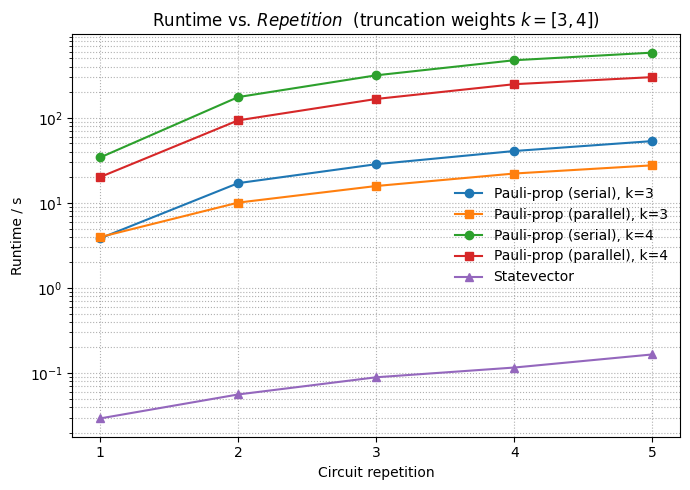

In [11]:
# ---------------------------------------------------------------------
# load all (L,k) benchmark results
# ---------------------------------------------------------------------
with open(f"results/su4_time_expectation_{nx}_{ny}.json") as f:
    data = json.load(f)

# helper to unpack key "L3_k2"  ->  (3,2)
def parse_key(tag):
    L_str, k_str = tag.split('_')
    return int(L_str[1:]), int(k_str[1:])

# ---------------------------------------------------------------------
# FIGURE 1 – runtime vs. L (fixed k_ref)
# ---------------------------------------------------------------------
k_refs = [3, 4]                        # which k slices to display

# collect and sort all L values (without list comprehension)
Ls_set = set()
for tag in data:
    L, _ = parse_key(tag)
    Ls_set.add(L)
Ls_sorted = sorted(list(Ls_set))

plt.figure(figsize=(7,5))

# plot curves for each k_ref value
for k_ref in k_refs:
    # fill three time curves sequentially
    time_serial, time_parallel, time_sv = [], [], []
    for L in Ls_sorted:
        key = f"L{L}_k{k_ref}"
        time_serial.append(data[key]["pauli_prop_serial"]["time_sec"])
        time_parallel.append(data[key]["pauli_prop_parallel"]["time_sec"])
        time_sv.append(data[key]["statevector"]["time_sec"])
    
    plt.plot(Ls_sorted, time_serial,   '-o', label=f'Pauli-prop (serial), k={k_ref}')
    plt.plot(Ls_sorted, time_parallel, '-s', label=f'Pauli-prop (parallel), k={k_ref}')

# plot statevector only once (it doesn't depend on k)
time_sv = []
for L in Ls_sorted:
    key = f"L{L}_k{k_refs[0]}"  # use first k_ref since statevector time is independent of k
    time_sv.append(data[key]["statevector"]["time_sec"])
plt.plot(Ls_sorted, time_sv, '-^', label='Statevector')

plt.xlabel('Circuit repetition')
plt.ylabel('Runtime / s')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xticks(Ls_sorted)
plt.title(f'Runtime vs. $Repetition$  (truncation weights $k={k_refs}$)')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


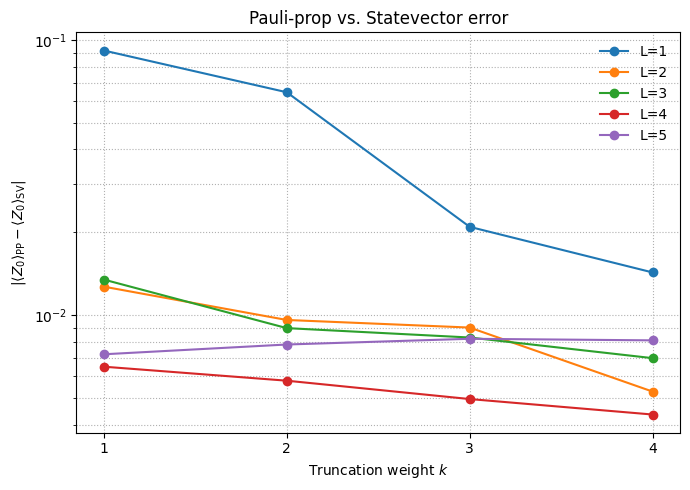

In [12]:
# ---------------------------------------------------------------------
# FIGURE 2 – |expect_PPauli − expect_SV| vs. k, for each L
# ---------------------------------------------------------------------
# collect and sort all k values
ks_set = set()
for tag in data:
    _, k = parse_key(tag)
    ks_set.add(k)
ks_sorted = sorted(list(ks_set))

plt.figure(figsize=(7,5))
for L in Ls_sorted:
    err = []
    for k in ks_sorted:
        key = f"L{L}_k{k}"
        e_pp = data[key]["pauli_prop_parallel"]["expectation"]
        e_sv = data[key]["statevector"]["expectation"]
        err.append(abs(e_pp - e_sv))
    plt.plot(ks_sorted, err, '-o', label=f'L={L}')

plt.xlabel('Truncation weight $k$')
plt.ylabel(r'$|\langle Z_0\rangle_{\mathrm{PP}} - \langle Z_0\rangle_{\mathrm{SV}}|$')
plt.yscale('log')
plt.xticks(ks_sorted)
plt.title('Pauli-prop vs. Statevector error')
plt.legend(frameon=False)
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()
